In [7]:
import pandas as pd
import json
import matplotlib.pyplot as plt
import json


In [25]:
def load_metrics(filename):
    with open(filename, 'r') as f:
        metrics = json.load(f)
        return pd.DataFrame(metrics)

In [37]:
metrics = [ {'label': 'Simple',
             'df': load_metrics('metrics/training_metrics_scratch_01.json'),
             'colours': '#1f77b4'},
            {'label': 'Medium',
             'df': load_metrics('metrics/training_metrics_scratch_05.json'),
             'colours': '#ff7f0e'},
            {'label': 'Complex',
             'df': load_metrics('metrics/training_metrics_scratch_06.json'),
             'colours': '#2ca02c'}]

In [53]:
def plot_metrics(metrics, image_path):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
    for single_metric in metrics:
        df = single_metric['df']
        colours = single_metric['colours']
        label = single_metric['label']
        axes[0].plot(df['epoch'], df['train_loss'], label=f'Train Loss [{label}]', color=colours, linestyle='-', linewidth=4)
        axes[1].plot(df['epoch'], df['train_accuracy'], label=f'Train Accuracy [{label}]', color=colours, linestyle='-', linewidth=4)

        axes[0].plot(df['epoch'], df['test_loss'], label=f'Validation Loss [{label}]', color=colours, linestyle='-.', linewidth=2)
        axes[1].plot(df['epoch'], df['test_accuracy'], label=f'Validation Accuracy [{label}]', color=colours, linestyle='-.', linewidth=2)

    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    axes[0].set_title('Training and Validation Loss')
    axes[0].legend()
    axes[0].grid(True)
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Accuracy')
    axes[1].set_title('Training and Validation Accuracy')
    axes[1].legend()
    axes[1].grid(True)
    plt.tight_layout()

    plt.savefig(image_path, bbox_inches='tight')
    plt.show()


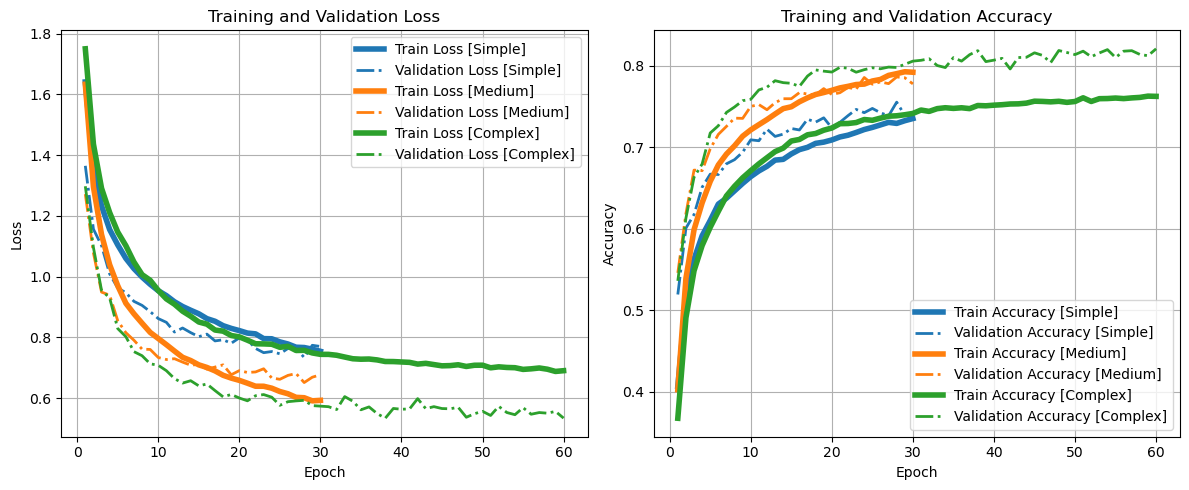

In [54]:
plot_metrics(metrics, image_path='report/media/training_metrics_scratch_01.png')